In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import shutil

# from plot import * #load_array

### Get all original .pkl from the root direcory

In [2]:
def get_file_paths(root_dir):
    file_paths = [os.path.join(root_dir, file_name) for file_name in os.listdir(root_dir) if file_name.endswith(".pkl")]
    return file_paths

folder_path = "/home/k45848/multispectral-imagery-segmentation/data/original_data"
get_file_paths(folder_path)

['/home/k45848/multispectral-imagery-segmentation/data/original_data/region_2_east_2023_05_31_final_data.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/region_2_east_2024_02_25_final_data.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/areas_without_trees_east_raster_final.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/region_1_west_2023_09_26_final_data.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/region_1_west_2024_02_28_final_data.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/areas_without_trees_west_raster_final.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/region_2_east_2023_09_28_final_data.pkl',
 '/home/k45848/multispectral-imagery-segmentation/data/original_data/region_1_west_2023_05_31_final_data.pkl']

### Load .pkl files 
Append the labels to the multispectral image array

In [3]:
def get_file_paths(root_dir):
    file_paths = [os.path.join(root_dir, file_name) for file_name in os.listdir(root_dir) if file_name.endswith(".pkl")]
    return file_paths

def load_array(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)
    
def combine_data_label(root_dir):
    """Combine the label arrays to the data, so has to create the final label (from 13 channels to 15 or so)
    input  8 files
    output 6 files"""
    file_paths = get_file_paths(root_dir=root_dir)

    arrays = {}
    for path in file_paths:
        array = load_array(path)

        # Extract file name without extension (.pkl) as key
        key = os.path.splitext(os.path.basename(path))[0]

        # Store arrays in dictionary (all data and label files)
        arrays[key] = array

    for key in arrays.keys():
        # Check if the key contains 'without_trees'
        if 'without_trees' in key:
            # Extract cardinal point from the key
            cardinal_point = key.split('_')[-3]
            
            # Find matching keys without 'without_trees' and the same cardinal point
            matching_keys = [k for k in arrays.keys() if cardinal_point in k and 'without_trees' not in k]
            
            # Iterate through matching keys and update arrays
            for match_key in matching_keys:
                # Add the first two channels from the 'without_trees' array to the matching array
                arrays[match_key] = np.concatenate([arrays[match_key], arrays[key][...]], axis=-1)

    mask = 'without_trees'
    arrays = {key: value for key, value in arrays.items() if mask not in key}

    return arrays

arrays = combine_data_label(root_dir=folder_path)
for key, value in arrays.items():
    print(key, value.shape)   
        

region_2_east_2023_05_31_final_data (746, 744, 15)
region_2_east_2024_02_25_final_data (746, 744, 15)
region_1_west_2023_09_26_final_data (931, 932, 15)
region_1_west_2024_02_28_final_data (931, 932, 15)
region_2_east_2023_09_28_final_data (746, 744, 15)
region_1_west_2023_05_31_final_data (931, 932, 15)


In [4]:
for key, value in arrays.items():
    print(key)
    print(np.unique(value[...,10], return_counts=True))
    
 

region_2_east_2023_05_31_final_data
(array([0., 1.], dtype=float32), array([211064, 343960]))
region_2_east_2024_02_25_final_data
(array([0., 1.], dtype=float32), array([245556, 309468]))
region_1_west_2023_09_26_final_data
(array([0., 1.], dtype=float32), array([423854, 443838]))
region_1_west_2024_02_28_final_data
(array([0., 1.], dtype=float32), array([421453, 446239]))
region_2_east_2023_09_28_final_data
(array([0., 1.], dtype=float32), array([215878, 339146]))
region_1_west_2023_05_31_final_data
(array([0., 1.], dtype=float32), array([421453, 446239]))


In [5]:
# items = list(arrays.items())

# Add deforested class (1) to channel 11 so it changes from (0,1) to (0,1,2 [invalid, deforested, forest])
for key, array in arrays.items():
    # Extract timestamp from key
    time_stamp_match = re.search(r'(\d{4})_(\d{2})_(\d{2})', key)
    if time_stamp_match:
        year = time_stamp_match.group(1)
        month = time_stamp_match.group(2)
        day = time_stamp_match.group(3)
        ts = float(year[2:] + month + day)  # Convert to float timestamp
    else:
        continue  # Skip if no timestamp found

    # Define deforested condition
    deforested_condition = (array[..., 10] == 1) & (array[..., 11] > 0) & (array[..., 12] <= ts)

    # Step 1: Set all 1s in the 11th channel to 2
    array[array[..., 10] == 1, 10] = 2

    # Step 2: Revert elements that meet the condition back to 1
    array[deforested_condition, 10] = 1

    # Make a new channel where deforested class pixels are split into their different vegetation cover
    # Add a new channel, initialise to zero
    veg_mask = np.zeros(array.shape[:-1] +(1,))
    array = np.concatenate((array, veg_mask), axis=-1)

    condition_1 = (array[..., 10] == 2)
    array[condition_1, 15] = 5

    condition_2 = (array[..., 10] == 1) & (array[..., 14] == 1)
    array[condition_2, 15] = 1

    condition_3 = (array[..., 10] == 1) & (array[..., 14] == 2)
    array[condition_3, 15] = 2

    condition_4 = (array[..., 10] == 1) & (array[..., 14] == 3)
    array[condition_4, 15] = 3

    condition_5 = (array[..., 10] == 1) & (array[..., 14] == 4)
    array[condition_5, 15] = 4

    """At this point array has 16 channels: 10 spectral, 1 mask, 4 attributes and 1 veg mask"""
    # Create a new channel to take into account the weather season, making it 17 channels
    if '2023_05'  in key:
        season_mask = np.zeros(array.shape[:-1]+ (1,))
    elif '2023_09' in key:
        season_mask = np.ones(array.shape[:-1]+ (1,))
    elif '2024_02' in key:
        season_mask = np.full(array.shape[:-1]+ (1,), 2)     

    array = np.concatenate((array, season_mask), axis=-1)

    # Delete the attribute channels (id, timestamp, ...)
    # Should have just 13 channels left
    array = np.delete(array, [11,12,13,14], axis=-1)

    arrays[key] = array

    print(np.unique(array[...,11], return_counts=True))





(array([0., 1., 2., 3., 5.]), array([211064,   1159,    316,    202, 342283]))
(array([0., 1., 2., 3., 5.]), array([245556,   6706,    399,    202, 302161]))
(array([0., 1., 2., 3., 4., 5.]), array([423854,   4149,    861,    445,   1431, 436952]))
(array([0., 1., 2., 3., 4., 5.]), array([421453,   4442,    861,    445,   1431, 439060]))
(array([0., 1., 2., 3., 5.]), array([215878,   6208,    399,    202, 332337]))
(array([0., 1., 2., 3., 4., 5.]), array([421453,   1011,    651,    445,   1431, 442701]))


At this point from the output from the preceeding cell array[..., 12] is time stamp mask. Since it's 
an input feature we would move it to position 10

In [6]:
def swap_channels(arr):
    arr[..., [11, 12, 10]] = arr[..., [10, 11, 12]]
    return arr

final_arrays = {key: swap_channels(value) for key, value in arrays.items()}

In [7]:
# print(np.unique(array[...,10], return_counts=True))

In [12]:
for key, value in arrays.items():
    print(key)
    print(np.unique(value[...,11], return_counts=True))

region_2_east_2023_05_31_final_data
(array([0., 1., 2.]), array([211064,   1677, 342283]))
region_2_east_2024_02_25_final_data
(array([0., 1., 2.]), array([245556,   7307, 302161]))
region_1_west_2023_09_26_final_data
(array([0., 1., 2.]), array([423854,   6886, 436952]))
region_1_west_2024_02_28_final_data
(array([0., 1., 2.]), array([421453,   7179, 439060]))
region_2_east_2023_09_28_final_data
(array([0., 1., 2.]), array([215878,   6809, 332337]))
region_1_west_2023_05_31_final_data
(array([0., 1., 2.]), array([421453,   3538, 442701]))


In [14]:
for k, v in arrays.items():
    with open(f"/home/k45848/multispectral-imagery-segmentation/data/08.06/{k}.pkl", 'wb') as file:
        pickle.dump(v, file)

CREATE PATCHES

08.06.2024
New changes
- Save only patches that have class 1 (deforested)

In [15]:
def to_patches(file_path: str, patch_size: int, stride: int) -> None:
    """
    Convert an array to patches of a given size and stride and save them to train or eval directory.

    Parameters:
    - file_path (str): Path to the input array file.
    - patch_size (int): Size of each patch.
    - stride (int): Stride between patches.
    - train_dir (str): Directory to save train patches.
    - eval_dir (str): Directory to save eval patches.
    """
    array = load_array(file_path)
    file_name = os.path.splitext(os.path.basename(file_path))[0]  # Get file name without extension

    height, width, _ =  array.shape
    patch_height, patch_width = patch_size, patch_size
    stride_height, stride_width = stride, stride

    # Calculate the number of patches in each dimension
    num_patches_height = (height - patch_height) // stride_height + 1
    num_patches_width = (width - patch_width) // stride_width + 1

    # Determine the directory based on a random choice for train or eval
    base_dir =os.path.dirname(file_path)
    train_dir = f"{base_dir}/train/"
    eval_dir = f"{base_dir}/val/"
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(eval_dir):
        os.makedirs(eval_dir)


    # dir = train_dir if random.choice([True, False]) else eval_dir
    # Determine the directory based on the 80:20 split
    # dir = train_dir if random.random() < 0.8 else eval_dir
    # os.makedirs(dir)

    for i in range(num_patches_height):
        for j in range(num_patches_width):
            start_i = i * stride_height
            start_j = j * stride_width
            patch = array[start_i:start_i + patch_height, start_j:start_j + patch_width, :]
            if 1 in patch[:,:,11]:
                dir = train_dir if random.random() < 0.8 else eval_dir
                patch_filename = f"{dir}{file_name}_{i* num_patches_width + j + 1}.pkl"
             
                with open(patch_filename, 'wb') as f:
                    pickle.dump(patch, f)


folder_path = "/home/k45848/multispectral-imagery-segmentation/data/08.06"
file_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".pkl")]
for path in file_paths:
    to_patches(path, patch_size=64, stride=16)

In [2]:
def count_files(folder_path):
    files = os.listdir(folder_path)
    file_count = len(files)
    return file_count

folder_path = ["/home/k45848/multispectral-imagery-segmentation/data/08.06/val",
               "/home/k45848/multispectral-imagery-segmentation/data/08.06/train"]
for f in folder_path:
    num_files = count_files(f)
    print("Number of files in the folder:", num_files) #2952  #08.06 759 val, 3237 train
#Number of files in the folder: 11670

Number of files in the folder: 759
Number of files in the folder: 3237


CHECK WHICH PATCHES HAVE DEFORESTED PIXELS

In the dataset there is a very huge disparity in the amount of pixels that are forest areas and the deforested ones (very small). As a result, I would filter through all the patches and keep the patches that have a considerable amount of pixels that have deforested areas pixel == 1

In [21]:

# Function to check if value 2 exists in the last channel of the third dimension
def check_value(arr):
    return 1 in arr[:,:,11]

def filter_files(source_dir, destination_dir):
    # Create destination directory of the filtered files if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith(".pkl"):
            file_path = os.path.join(source_dir, filename)

            # Load data from pickle file
            with open(file_path, 'rb') as f:
                data = pickle.load(f)

            # Check if value 2 exists in the last channel of the third dimension
            if check_value(data):
                # Copy the file to the destination directory
                shutil.copy(file_path, destination_dir)



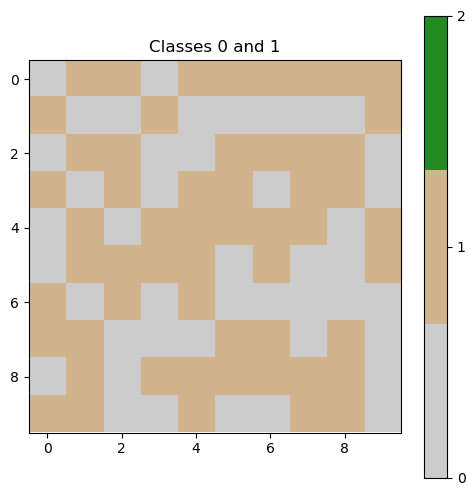

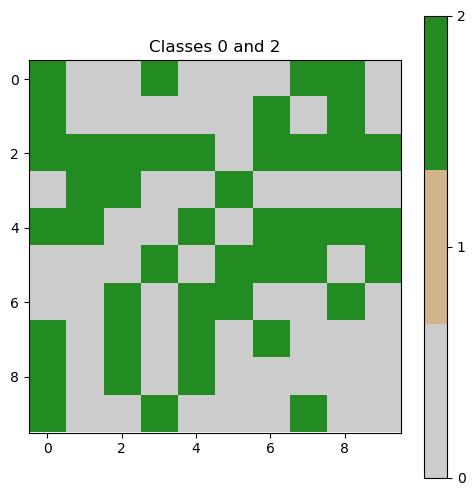

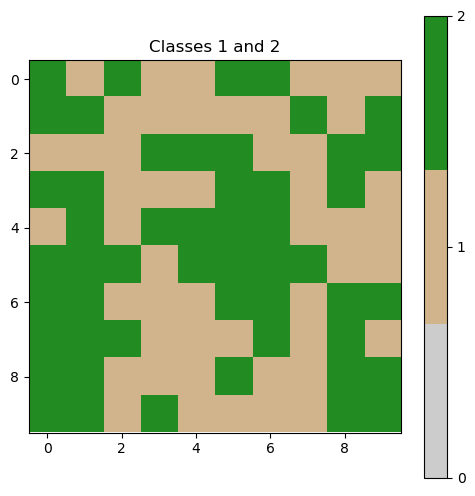

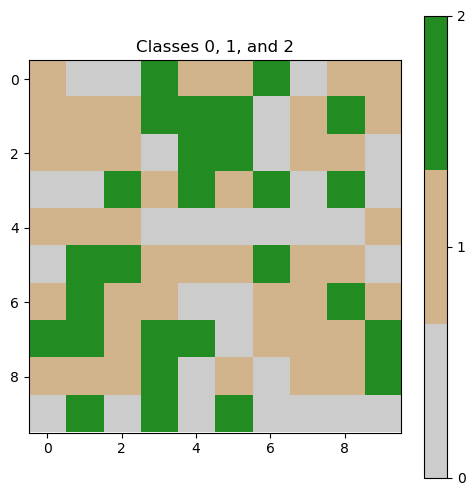

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the custom color map
colors = ["#CCCCCC", "#D2B48C", "#228B22"]
cmap = mcolors.ListedColormap(colors)

# Generate random arrays with varying class constituents
np.random.seed(0)  # For reproducibility

# Function to plot the segmentation map
def plot_segmentation_map(array, cmap, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(array, cmap=cmap, vmin=0, vmax=2)
    plt.title(title)
    plt.colorbar(ticks=[0, 1, 2], format=plt.FuncFormatter(lambda x, _: int(x)))
    plt.show()

# Generate and plot test arrays
array_0_1 = np.random.choice([0, 1], size=(10, 10))
array_0_2 = np.random.choice([0, 2], size=(10, 10))
array_1_2 = np.random.choice([1, 2], size=(10, 10))
array_all = np.random.choice([0, 1, 2], size=(10, 10))

# Plot the arrays
plot_segmentation_map(array_0_1, cmap, "Classes 0 and 1")
plot_segmentation_map(array_0_2, cmap, "Classes 0 and 2")
plot_segmentation_map(array_1_2, cmap, "Classes 1 and 2")
plot_segmentation_map(array_all, cmap, "Classes 0, 1, and 2")
